In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FOUNDATIONS = ["authority", "care", "fairness", "loyalty", "sanctity"]
COLORS = ["darkviolet", "mediumblue", "mediumseagreen", "indianred", "goldenrod"]

## Load dataset and predictions

In [3]:
data = pd.read_csv("mfd/data/mfd_scoring_results/mf_merged_roberta.csv", index_col=0)
data.drop(columns=["tokens"], inplace=True)
data.head(2)

,sentence,authority_label,authority_train,care_label,care_train,fairness_label,fairness_train,loyalty_label,loyalty_train,sanctity_label,...,care_fold,fairness_fold,loyalty_fold,sanctity_fold,none_fold,authority_score,care_score,fairness_score,loyalty_score,sanctity_score
0,"Betsy DeVos, President Trump's nominee for edu...",1,1,1,1,1,1,-1,-1,1,...,5,8,-1,7,10,0.832013,0.82923,0.731822,0.785273,0.668990
1,DeVos went on to write that she is 'eager to b...,1,1,0,1,1,1,-1,-1,1,...,5,2,-1,9,2,0.709451,0.62563,0.502918,0.471925,0.600735


In [4]:
def get_labels_and_scores(foundation, train=False, corpus="all", ground_truth=None):
    assert corpus in ["twitter", "reddit", "news", "all"]
    if corpus == "news": data_f = data.iloc[:34262,:]
    elif corpus == "reddit": data_f = data.iloc[34262:34262 + 17886, :]
    elif corpus == "twitter": data_f = data.iloc[34262 + 17886:, :]
    else: data_f = data
    if train:
        # Labels and predicted scores for the training examples
        data_f = data_f[data_f[f"{foundation}_fold"] != 0]
        data_f = data_f[data_f[f"{foundation}_fold"] != -1]
    else:
        # Labels and predicted scores for the test examples
        data_f = data_f[data_f[f"{foundation}_fold"] == 0]
    if ground_truth is not None:
        data_f = data_f[data_f[f"{foundation}_label"] == ground_truth]
    y_true = data_f[f"{foundation}_label"]
    y_score = data_f[f"{foundation}_score"]
    return y_true, y_score

In [5]:
# data = pd.read_csv("mfd/data/mf_corpora_merged.csv", index_col=0)

## Histograms of predicted scores

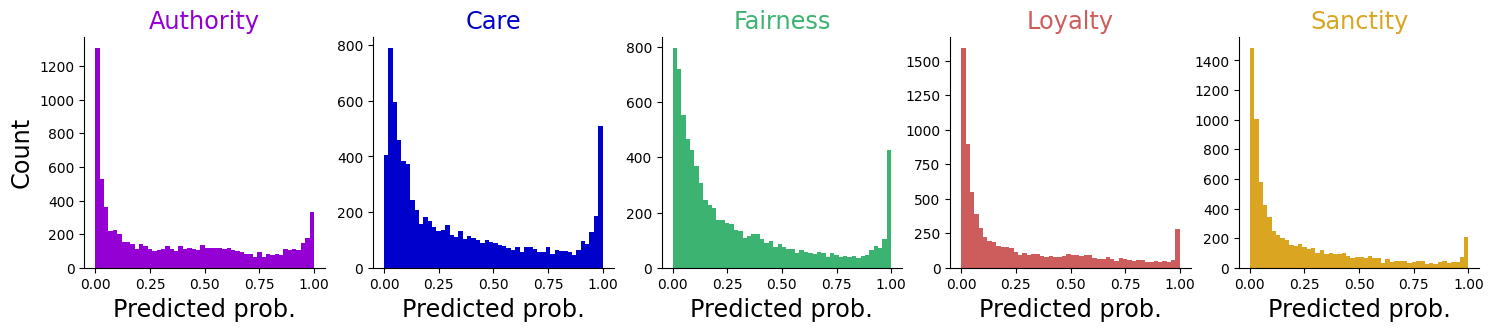

In [6]:
fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3))
for ax, foundation, color in zip(axes, FOUNDATIONS, COLORS):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    
    ax.hist(
        y_score,
        range=(0, 1),
        bins=50,
        label=foundation,
        color=color,
    )
    ax.set_title(foundation.capitalize(), size="xx-large", color=color)
    ax.set_xlabel("Predicted prob.", size="xx-large")
    ax.set_ylabel(None)
axes[0].set_ylabel("Count", size="xx-large")
sns.despine()
plt.savefig("figs/roberta_evaluation/testset_predicted_probs.pdf",
            bbox_inches="tight")
plt.show()

## Distribution of posteriors

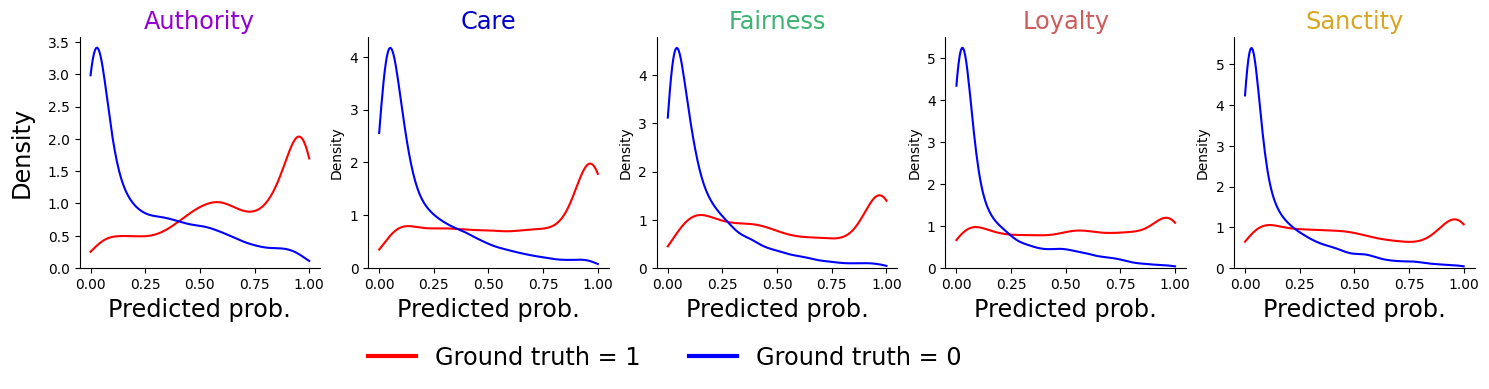

In [7]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3))
for ax, foundation, color in zip(axes, FOUNDATIONS, COLORS):
    # Scores for positive examples
    y_true, y_score = get_labels_and_scores(foundation, train=False, ground_truth=1)
    
    sns.kdeplot(
        y_score,
        ax=ax,
        color="red",
        clip=[0, 1]
    )
    
    # Scores for negative examples
    
    y_true, y_score = get_labels_and_scores(foundation, train=False, ground_truth=0)
    
    sns.kdeplot(
        y_score,
        ax=ax,
        color="blue",
        clip=[0, 1]
    )
    
    ax.set_title(foundation.capitalize(), size="xx-large", color=color)
    ax.set_xlabel("Predicted prob.", size="xx-large", )
axes[0].set_ylabel("Density", size="xx-large", labelpad=10)

custom_lines = [Line2D([0], [0], color="red", lw=3),
                Line2D([0], [0], color="blue", lw=3)]
fig.legend(custom_lines, ['Ground truth = 1', 'Ground truth = 0'],
           frameon=False,
           ncol=2,
           prop={'size': "xx-large"},
           loc="lower center",
           bbox_to_anchor=(0.45, -0.3, 0, 0))
sns.despine()
plt.savefig("figs/roberta_evaluation/testset_posteriors.pdf",
            bbox_inches="tight")

plt.show()

## Calibration curve

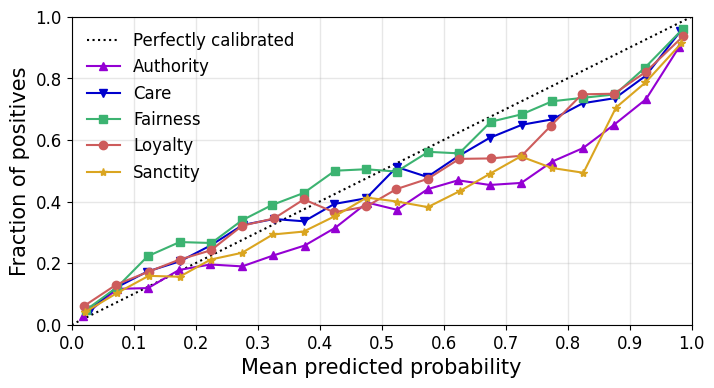

In [8]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
MARKERS = ["^", "v", "s", "o", "*"]
n_bins = 20
fig, ax = plt.subplots(figsize=(8, 4))

# Perfect calibration
ax.plot([0, 1.0], [0, 1.0], c="k", linestyle="dotted", label="Perfectly calibrated")

for foundation, color, marker in zip(FOUNDATIONS, COLORS, MARKERS):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    
    # Get fraction of pos and mean predicted prob
    prob_true, prob_pred = calibration_curve(y_true, y_score, n_bins=n_bins)
    ax.plot(prob_pred, prob_true, c=color, marker=marker, label=foundation.capitalize())


ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.grid(alpha=0.3, linestyle="-", linewidth=1)
ax.legend(prop={'size': "large"}, frameon=False)
ax.set_xlabel("Mean predicted probability", size=15)
ax.set_ylabel("Fraction of positives", size=15)
ax.set_xticks(np.linspace(0, 1.0, 11))
ax.set_yticks(np.linspace(0, 1.0, 6))
ax.tick_params(axis='both', which='major', labelsize="large")
plt.savefig("figs/roberta_evaluation/testset_calibration_raw.pdf", bbox_inches="tight")
plt.show()

### Calibrate the scores

In [9]:
# Saerens, Latinne, and Decaestecke (2002)
def calibrate(y_test_score, y_train):
    train_pos_prop = np.mean(y_train)
    neg_to_pos_prop = (1 - train_pos_prop) / train_pos_prop
    test_score = y_test_score / (y_test_score + neg_to_pos_prop * (1 - y_test_score))
    return test_score

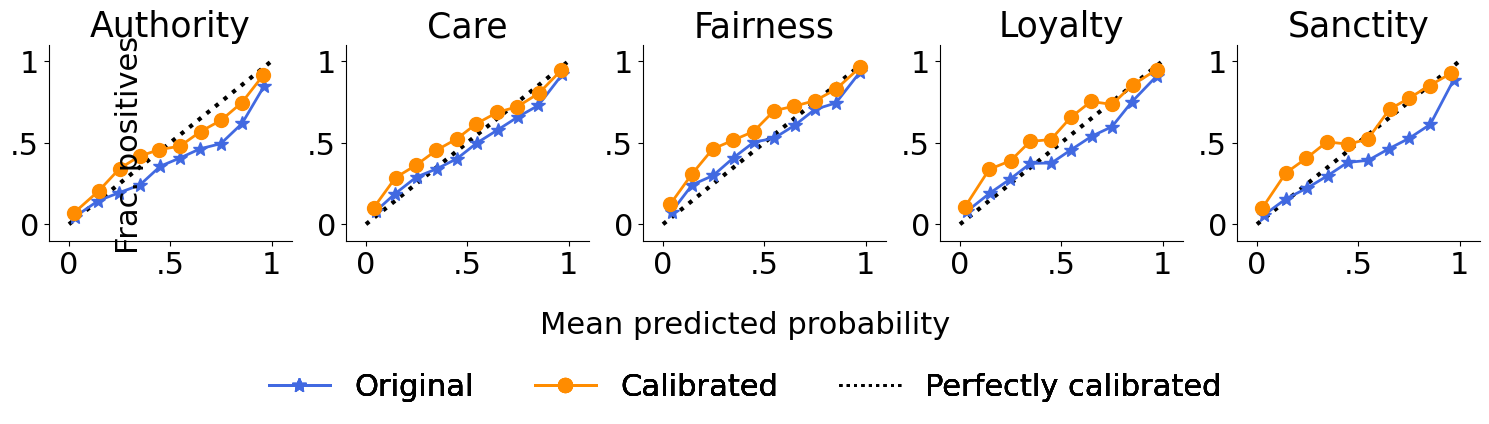

In [10]:
from sklearn.calibration import calibration_curve, CalibrationDisplay
fig, axes = fig, axes = plt.subplots(1, 5, figsize=(15, 3))
n_bins = 10
for ax, color, foundation in zip(axes, COLORS, FOUNDATIONS):
    y_train_true, y_train_score = get_labels_and_scores(foundation, train=True)
    y_test_true, y_test_score = get_labels_and_scores(foundation, train=False)
    y_test_score_calibrated = calibrate(y_test_score, y_train_true)
    
    ax.plot([0, 1.0], [0, 1.0], c="k", linestyle="dotted", label="Perfectly calibrated", lw=3)
    
    # Plot pre-calibrated curve
    prob_true, prob_pred = calibration_curve(y_test_true, y_test_score, n_bins=n_bins)
    ax.plot(prob_pred, prob_true, c="royalblue", marker="*", label=foundation.capitalize(),
            markersize=10, lw=2)
    
    # Plot the calibrated curve
    prob_true, prob_pred = calibration_curve(y_test_true, y_test_score_calibrated, n_bins=n_bins)
    ax.plot(prob_pred, prob_true, c="darkorange", marker="o", label=foundation.capitalize(),
            markersize=10, lw=2)
    
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks([0, 0.5, 1.0], ["0", ".5", "1"])
    ax.set_yticks([0, 0.5, 1.0], ["0", ".5", "1"])
    ax.tick_params(axis='both', which='major', labelsize=22)
    
    sns.despine(ax=ax)
    ax.set_title(foundation.capitalize(), size=25)
    
    custom_lines = [Line2D([0], [0], color="royalblue", marker="*", markersize=10, lw=2),
                    Line2D([0], [0], color="darkorange", marker="o", markersize=10, lw=2),
                    Line2D([0], [0], color="k", linestyle="dotted", markersize=10, lw=2)]
    fig.legend(custom_lines, ['Original', 'Calibrated', "Perfectly calibrated"],
               frameon=False,
               ncol=3,
               prop={'size': 22},
               loc="lower center",
               bbox_to_anchor=(0.5, -0.45, 0, 0))

fig.text(x=0.5, y=-0.13, s="Mean predicted probability", size=22, ha="center")
fig.text(x=0.08, y=0.5, s="Frac. positives", size=22, va="center", rotation=90)

plt.savefig("figs/roberta_evaluation/testset_calibration_calibrated.pdf", bbox_inches="tight")
    
fig.tight_layout()

### Brier score after calibration

In [11]:
from sklearn.metrics import brier_score_loss

brier_scores = pd.DataFrame(0, columns=FOUNDATIONS, index=["Original", "Calibrated"])

for color, foundation in zip(COLORS, FOUNDATIONS):
    y_train_true, y_train_score = get_labels_and_scores(foundation, train=True)
    y_test_true, y_test_score = get_labels_and_scores(foundation, train=False)
    y_test_score_calibrated = calibrate(y_test_score, y_train_true)
    
    brier_scores.loc["Original", foundation] = brier_score_loss(y_prob=y_test_score, y_true=y_test_true)
    brier_scores.loc["Calibrated", foundation] = brier_score_loss(y_prob=y_test_score_calibrated, y_true=y_test_true)

brier_scores

,authority,care,fairness,loyalty,sanctity
Original,0.153536,0.145897,0.149052,0.139666,0.125006
Calibrated,0.143978,0.150533,0.161912,0.148102,0.129586


### Mean squared error to the perfectly calibrated curve

In [12]:
mse_scores = pd.DataFrame(0, columns=FOUNDATIONS, index=["Original", "Calibrated"])

for color, foundation in zip(COLORS, FOUNDATIONS):
    y_train_true, y_train_score = get_labels_and_scores(foundation, train=True)
    y_test_true, y_test_score = get_labels_and_scores(foundation, train=False)
    y_test_score_calibrated = calibrate(y_test_score, y_train_true)
    
    prob_true, prob_pred = calibration_curve(y_test_true, y_test_score, n_bins=n_bins)
    mse_scores.loc["Original", foundation] = np.mean((prob_true - prob_pred) ** 2)
    
    prob_true, prob_pred = calibration_curve(y_test_true, y_test_score_calibrated, n_bins=n_bins)
    mse_scores.loc["Calibrated", foundation] = np.mean((prob_true - prob_pred) ** 2)

pd.options.display.float_format = "{:,.5f}".format
mse_scores

,authority,care,fairness,loyalty,sanctity
Original,0.02135,0.00405,0.00379,0.00687,0.01855
Calibrated,0.00565,0.00637,0.01527,0.01177,0.00923


### Precision-recall curve

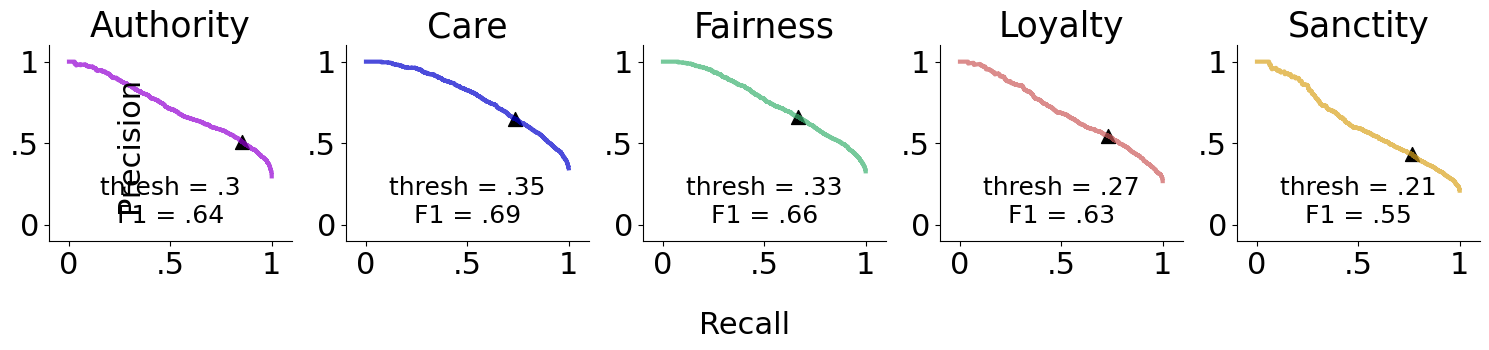

In [13]:
from utils.evaluation import evaluate_binary_scorer_fold
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = {}
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, color, foundation in zip(axes, COLORS, FOUNDATIONS):
    y_train_true, y_train_score = get_labels_and_scores(foundation, train=True)
    y_test_true, y_test_score = get_labels_and_scores(foundation, train=False)
    
    # Plot PR curve
    result = evaluate_binary_scorer_fold(
        y_true=y_test_true, 
        y_score=y_test_score,
        y_pred=np.array([y >= 0.5 for y in y_test_score], dtype=int)
    )
    recall, precision = result["pr_curve"]["recall"], result["pr_curve"]["precision"]
    ax.plot(recall, precision, color=color, alpha=0.7, lw=3)
    
    # Mark threshold
    threshold = calibrate(0.5, y_train_true)
    thresholds[foundation] = threshold
    y_test_pred_calibrated = np.array([y >= threshold for y in y_test_score], dtype=int)
    prec = precision_score(y_true=y_test_true, y_pred=y_test_pred_calibrated)
    rec = recall_score(y_true=y_test_true, y_pred=y_test_pred_calibrated)
    f1 = f1_score(y_true=y_test_true, y_pred=y_test_pred_calibrated)
    
    ax.scatter([rec], [prec], marker="^", color="black", s=100)
    
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks([0, 0.5, 1.0], ["0", ".5", "1"])
    ax.set_yticks([0, 0.5, 1.0], ["0", ".5", "1"])
    ax.tick_params(axis='both', which='major', labelsize=22)
    
    sns.despine(ax=ax)
    ax.set_title(foundation.capitalize(), size=25)
    
    ax.text(x=0.5, y=-0.02, s=f"thresh = {str(round(threshold, 2))[1:]}\nF1 = {str(round(f1, 2))[1:]}", 
            ha="center", va="bottom", size=18)
    

fig.text(x=0.5, y=-0.13, s="Recall", size=22, ha="center")
fig.text(x=0.08, y=0.5, s="Precision", size=22, va="center", rotation=90)

plt.savefig("figs/roberta_evaluation/testset_calibration_f1.pdf", bbox_inches="tight")
    
fig.tight_layout()

## ROC curve: threshold-free, class prior independent

In [14]:
def plot_roc_curve(fpr, tpr, color, ax):
    ax.plot(fpr, tpr, lw=3, alpha=1, c=color)
    ax.plot([0, 1], [0, 1], linestyle='--', linewidth=2, c='k')
    ax.grid(alpha=0.5, linestyle=':', linewidth=2)
    
    # Customize x ticks
    ax.set_xticks(np.arange(0, 1.1, 0.1))
    ax.set_xticklabels(labels=list(map(lambda x: str(x)[1:3] if x < 1 else str(x)[0:2], np.arange(0, 1.1, 0.1))),
                       fontdict={"fontsize": "large"})
    
    # Customize y ticks
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(labels=list(map(lambda x: str(x)[1:3] if x < 1 else str(x)[0:2], np.arange(0, 1.1, 0.1))),
                       fontdict={"fontsize": "large"})

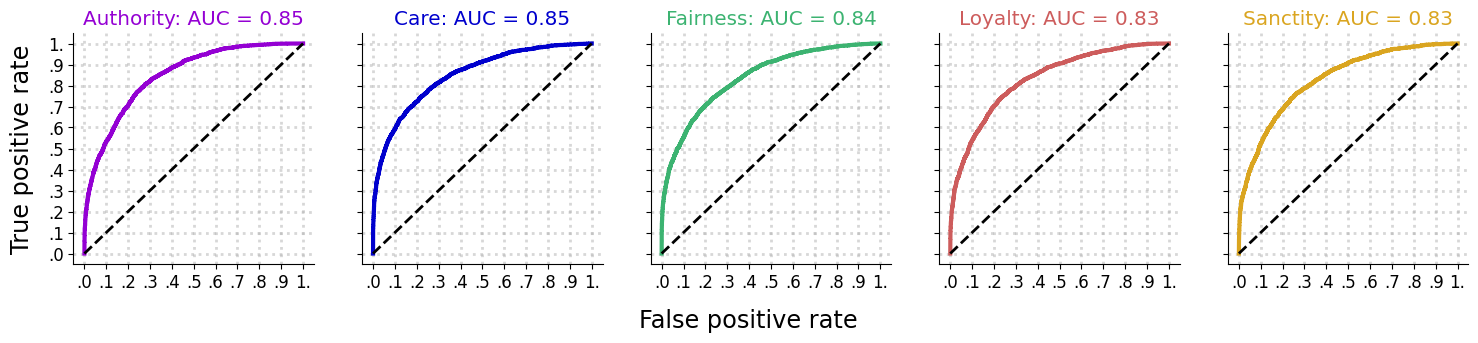

In [15]:
from utils.evaluation import evaluate_binary_scorer_fold
fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3), sharey=True)

for foundation, color, ax in zip(FOUNDATIONS, COLORS, axes):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    naive_y_pred = np.array([y >= 0.5 for y in y_score], dtype=int)
    
    results = evaluate_binary_scorer_fold(y_true=y_true, y_pred=naive_y_pred, y_score=y_score)
    roc = results["roc_curve"]
    
    plot_roc_curve(fpr=roc["fpr"], tpr=roc["tpr"], color=color, ax=ax)
    
    ax.set_title(f"{foundation.capitalize()}: AUC = {roc['auc']:.2f}", size="x-large", color=color)

fig.text(0.5, -0.04, "False positive rate", va="top", ha="center", size="xx-large")
axes[0].set_ylabel("True positive rate", size="xx-large", labelpad=10)

sns.despine()

plt.savefig("figs/roberta_evaluation/testset_ROC_all.pdf",
            bbox_inches="tight")

plt.show()

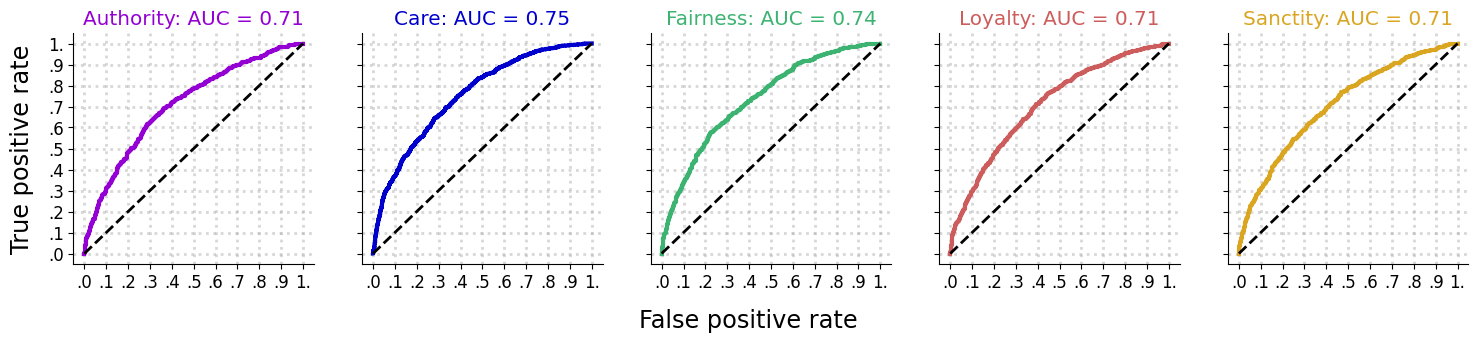

In [16]:
from utils.evaluation import evaluate_binary_scorer_fold
fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3), sharey=True)

for foundation, color, ax in zip(FOUNDATIONS, COLORS, axes):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False, corpus="news")
    naive_y_pred = np.array([y >= 0.5 for y in y_score], dtype=int)
    
    results = evaluate_binary_scorer_fold(y_true=y_true, y_pred=naive_y_pred, y_score=y_score)
    roc = results["roc_curve"]
    
    plot_roc_curve(fpr=roc["fpr"], tpr=roc["tpr"], color=color, ax=ax)
    
    ax.set_title(f"{foundation.capitalize()}: AUC = {roc['auc']:.2f}", size="x-large", color=color)

fig.text(0.5, -0.04, "False positive rate", va="top", ha="center", size="xx-large")
axes[0].set_ylabel("True positive rate", size="xx-large", labelpad=10)
sns.despine()
plt.savefig("figs/roberta_evaluation/testset_ROC_news.pdf",
            bbox_inches="tight")

plt.show()

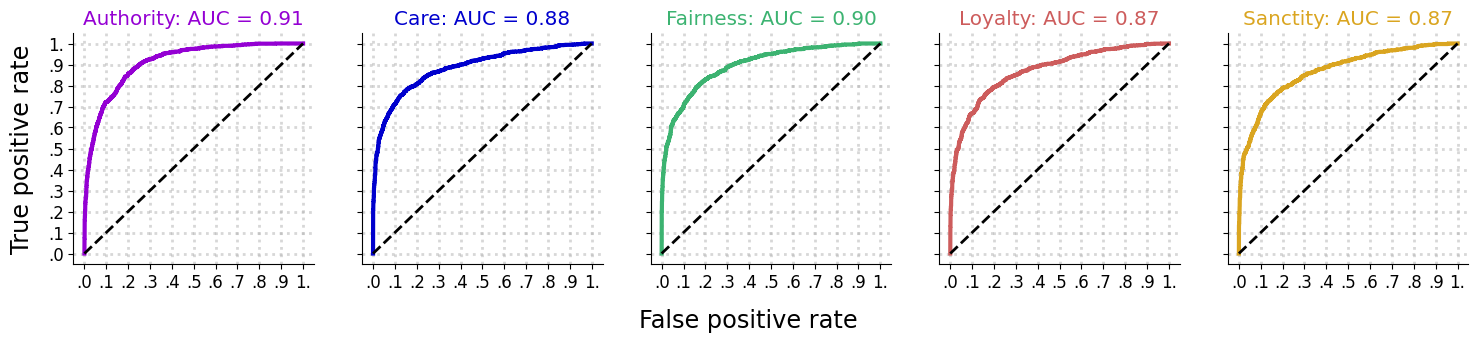

In [17]:
from utils.evaluation import evaluate_binary_scorer_fold
fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3), sharey=True)

for foundation, color, ax in zip(FOUNDATIONS, COLORS, axes):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False, corpus="twitter")
    naive_y_pred = np.array([y >= 0.5 for y in y_score], dtype=int)
    
    results = evaluate_binary_scorer_fold(y_true=y_true, y_pred=naive_y_pred, y_score=y_score)
    roc = results["roc_curve"]
    
    plot_roc_curve(fpr=roc["fpr"], tpr=roc["tpr"], color=color, ax=ax)
    
    ax.set_title(f"{foundation.capitalize()}: AUC = {roc['auc']:.2f}", size="x-large", color=color)

fig.text(0.5, -0.04, "False positive rate", va="top", ha="center", size="xx-large")
axes[0].set_ylabel("True positive rate", size="xx-large", labelpad=10)

sns.despine()

plt.savefig("figs/roberta_evaluation/testset_ROC_twitter.pdf",
            bbox_inches="tight")

plt.show()

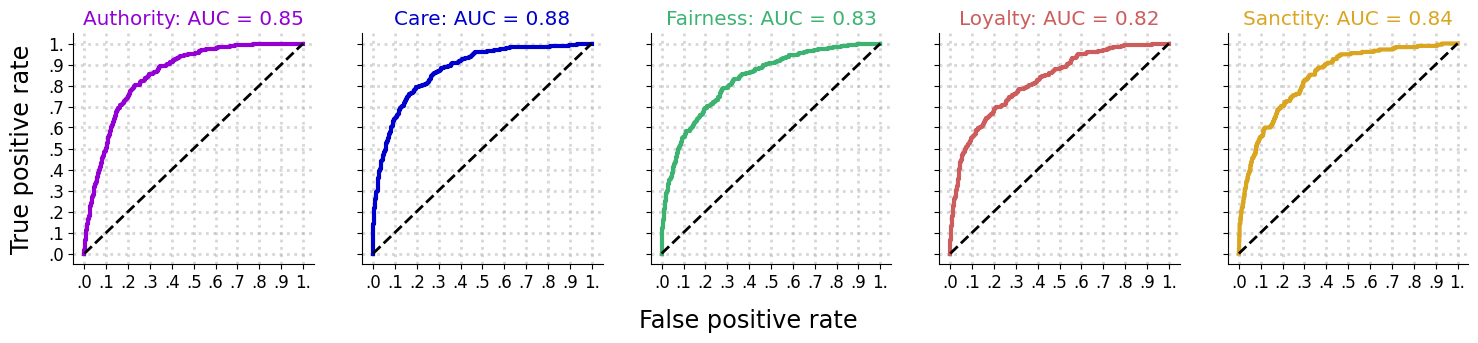

In [18]:
from utils.evaluation import evaluate_binary_scorer_fold
fig, axes = plt.subplots(1, len(FOUNDATIONS), figsize=(18, 3), sharey=True)

for foundation, color, ax in zip(FOUNDATIONS, COLORS, axes):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False, corpus="reddit")
    naive_y_pred = np.array([y >= 0.5 for y in y_score], dtype=int)
    
    results = evaluate_binary_scorer_fold(y_true=y_true, y_pred=naive_y_pred, y_score=y_score)
    roc = results["roc_curve"]
    
    plot_roc_curve(fpr=roc["fpr"], tpr=roc["tpr"], color=color, ax=ax)
    
    ax.set_title(f"{foundation.capitalize()}: AUC = {roc['auc']:.2f}", size="x-large", color=color)

fig.text(0.5, -0.04, "False positive rate", va="top", ha="center", size="xx-large")
axes[0].set_ylabel("True positive rate", size="xx-large", labelpad=10)

sns.despine()

plt.savefig("figs/roberta_evaluation/testset_ROC_reddit.pdf",
            bbox_inches="tight")

plt.show()

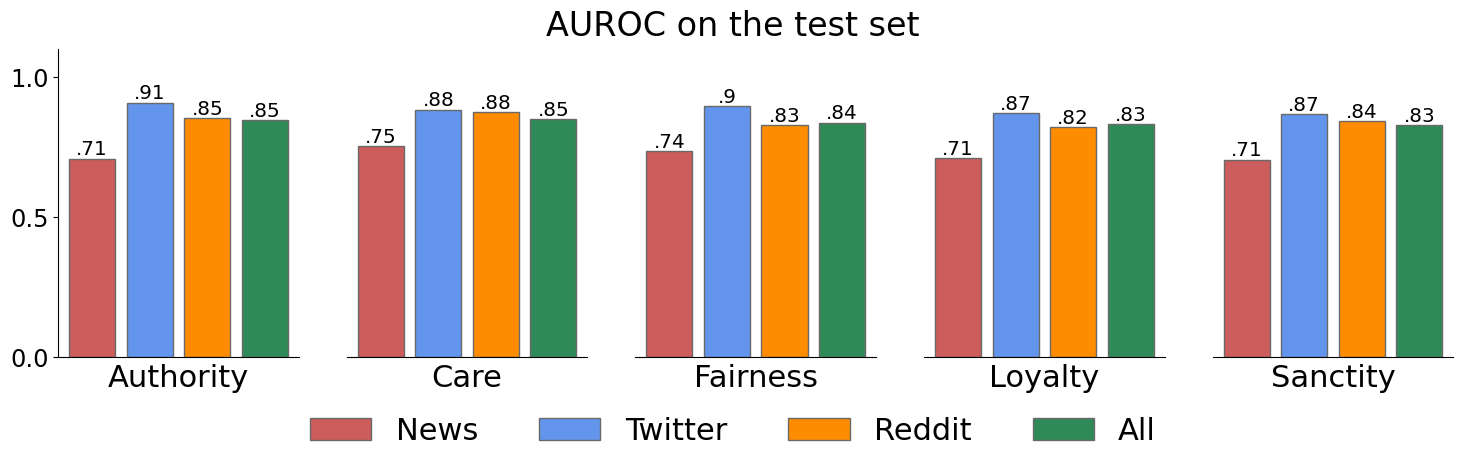

In [19]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 5, figsize=(18, 4))
corpora = ["news", "twitter", "reddit", "all"]
corpora_colors = ["indianred", "cornflowerblue", "darkorange", "seagreen"]
for i, (foundation, ax) in enumerate(zip(FOUNDATIONS, axes)):
    hist = []
    for corpus in corpora:
        y_true, y_score = get_labels_and_scores(foundation, train=False, corpus=corpus)
        naive_y_pred = np.array([y >= 0.5 for y in y_score], dtype=int)
        results = evaluate_binary_scorer_fold(y_true=y_true, y_pred=naive_y_pred, y_score=y_score)
        roc_auc = results["roc_curve"]["auc"]
        hist.append(roc_auc)
    ax.bar(np.arange(len(corpora)), hist, color=corpora_colors, edgecolor="dimgray")
    ax.set_ylim([0, 1.1])
    for j, val in enumerate(hist):
        ax.text(x=j, y=val, s=str(round(val, 2))[1:], size="x-large", va="bottom", ha="center")
    ax.set_xlabel(foundation.capitalize(), size=22)
    sns.despine(top=True, right=True, left=i > 0, ax=ax)
    if i > 0: ax.set_yticks([])
    if i == 0: 
        ax.set_yticks(np.arange(0, 1.1, 0.5))
        ax.tick_params(axis='y', which='major', labelsize="xx-large")
    ax.set_xticks([])
plt.subplots_adjust(wspace=0.2, hspace=0)

legend_elements = [Patch(facecolor='indianred', edgecolor='dimgray', label='News'),
                   Patch(facecolor='cornflowerblue', edgecolor='dimgray', label='Twitter'),
                   Patch(facecolor='darkorange', edgecolor='dimgray', label='Reddit'),
                   Patch(facecolor='seagreen', edgecolor='dimgray', label='All')]

fig.legend(handles=legend_elements,
           frameon=False,
           ncol=4,
           prop={'size': 22},
           loc="lower center",
           bbox_to_anchor=(0.5, -0.18, 0, 0))

fig.suptitle("AUROC on the test set", size=24)

plt.savefig("figs/roberta_evaluation/testset_AUC_all.pdf", bbox_inches="tight")

## Brier score: threshold-free, requires predicted scores to be probabilities

This is the MSE for binary prediction.

In [20]:
from sklearn.metrics import brier_score_loss
brier_scores = pd.Series(0, index=FOUNDATIONS)
for foundation, color, ax in zip(FOUNDATIONS, COLORS, axes):
    # Get labels and predicted scores
    y_true, y_score = get_labels_and_scores(foundation, train=False)
    
    brier_scores[foundation] = brier_score_loss(y_true=y_true, y_prob=y_score)

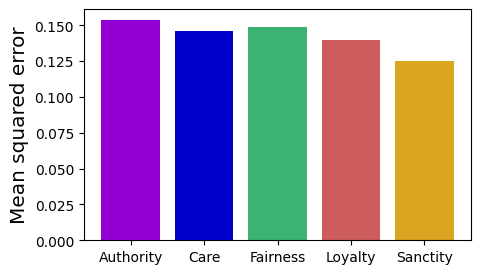

In [21]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(brier_scores.index, brier_scores.values, color=COLORS)
ax.set_xticks(range(len(FOUNDATIONS)), [f.capitalize() for f in FOUNDATIONS])
ax.set_ylabel("Mean squared error", size="x-large")
plt.show()

## Thresholding to find binary predictions

- Where TPR and FPR differ the most (method 1)
- Top X% of the scores (method 2)

In [22]:
def threshold_max_diff(train_tpr, train_fpr, train_thresholds, y_test_score):
    optimal_idx = np.argmax(train_tpr - train_fpr)
    threshold = train_thresholds[optimal_idx]
    y_pred = [y >= threshold for y in y_test_score]
    return np.array(y_pred, dtype=int)

def threshold_top_x(x, y_test_score):
    assert 0 <= x and x <= 100
    threshold = np.percentile(y_test_score, q=x)
    y_pred = [y >= threshold for y in y_test_score]
    return np.array(y_pred, dtype=int)

What to measure:
- Num examples
- % positives (label prior)
- Accuracy
- Precision
- Recall
- F-1
- Likelihood ratio

In [23]:
# Binary prediction results
from utils.evaluation import evaluate_binary_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score, class_likelihood_ratios, average_precision_score, matthews_corrcoef, \
    jaccard_score, roc_auc_score, balanced_accuracy_score

bin_pred_res = pd.DataFrame(0, index=FOUNDATIONS,
                            columns=["N", "%Pos", "Acc", "Bal. Acc", "Prec", "Rec", 
                                     "F1", "LR+", 
                                     # "Matthews", "Jaccard", 
                                     "Avg Prec", 
                                     "AUROC"])
for foundation in FOUNDATIONS:
    corpus = "reddit"
    y_train_true, y_train_score = get_labels_and_scores(foundation, train=True, corpus=corpus)
    y_test_true, y_test_score = get_labels_and_scores(foundation, train=False, corpus=corpus)
    
    bin_pred_res.loc[foundation, "N"] = len(y_test_true)
    bin_pred_res.loc[foundation, "%Pos"] = 100 * sum(y_test_true) / len(y_test_true)
    
    naive_y_train_pred = np.array([y >= 0.5 for y in y_train_score], dtype=int)
    train_results = evaluate_binary_scorer_fold(y_pred=naive_y_train_pred, 
                                                y_score=y_train_score, 
                                                y_true=y_train_true)
    
    # METHOD 1
    y_test_pred = threshold_max_diff(y_test_score=y_test_score, 
                                     train_fpr=train_results["roc_curve"]["fpr"],
                                     train_tpr=train_results["roc_curve"]["tpr"],
                                     train_thresholds=train_results["roc_curve"]["thresholds"])
    
    # METHOD 2
    y_test_pred = threshold_top_x(x=75, y_test_score=y_test_score)
    
    # METHOD 3: calibration
    y_test_pred = np.array([int(y >= thresholds[foundation]) for y in y_test_score],
                            dtype=int)
    
    bin_pred_res.loc[foundation, "Acc"] = accuracy_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "Prec"] = precision_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "Rec"] = recall_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "F1"] = f1_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "LR+"] = class_likelihood_ratios(y_true=y_test_true, y_pred=y_test_pred)[0]
    # bin_pred_res.loc[foundation, "Matthews"] = matthews_corrcoef(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "Avg Prec"] = average_precision_score(y_true=y_test_true, 
                                                                            y_score=y_test_score)
    #bin_pred_res.loc[foundation, "Jaccard"] = jaccard_score(y_true=y_test_true, y_pred=y_test_pred)
    bin_pred_res.loc[foundation, "AUROC"] = roc_auc_score(y_true=y_test_true, y_score=y_test_score)
    bin_pred_res.loc[foundation, "Bal. Acc"] = balanced_accuracy_score(y_true=y_test_true, y_pred=y_test_pred)

In [24]:
pd.options.display.float_format = "{:,.2f}".format
bin_pred_res.to_csv(f"figs/roberta_evaluation/testset_threshold_scores_{corpus}.csv")
bin_pred_res

,N,%Pos,Acc,Bal. Acc,Prec,Rec,F1,LR+,Avg Prec,AUROC
authority,1789,19.17,0.76,0.78,0.44,0.80,0.57,3.28,0.56,0.85
care,1789,26.50,0.82,0.79,0.63,0.74,0.68,4.75,0.74,0.88
fairness,1789,29.51,0.78,0.73,0.64,0.60,0.62,4.33,0.70,0.83
loyalty,1789,11.07,0.87,0.72,0.44,0.52,0.48,6.32,0.46,0.82
sanctity,1789,9.78,0.86,0.74,0.36,0.59,0.45,5.21,0.44,0.84


## Attention scores

In [25]:
from utils.roberta_utils import (
    load_model, # Load model from checkpoint
    get_attention_scores, # Extract attention scores for text,
    tokenizer, # RoBERTa tokenizer
)

In [26]:
# Load models for all foundations
labelers = {
    "authority": "/localdata/u7221462/dev/moral-predictor/experiments/merged/one-vs-all-combined/authority/checkpoints/trial-1-20221109-075214-762383/last.ckpt",
    "care": "/localdata/u7221462/dev/moral-predictor/experiments/merged/one-vs-all-combined/care/checkpoints/trial-1-20221114-034608-371367/last.ckpt",
    "fairness": "/localdata/u7221462/dev/moral-predictor/experiments/merged/one-vs-all-combined/fairness/checkpoints/trial-1-20221109-081812-371459/last.ckpt",
    "loyalty": "/localdata/u7221462/dev/moral-predictor/experiments/merged/one-vs-all-combined/loyalty/checkpoints/trial-1-20221109-072631-151450/last.ckpt",
    "sanctity": "/localdata/u7221462/dev/moral-predictor/experiments/merged/one-vs-all-combined/sanctity/checkpoints/trial-1-20221114-034611-278774/last.ckpt"
}

device = "cuda"
models = {f: load_model(labelers[f]).to(device) for f in labelers}

In [27]:
get_attention_scores(models=models, text="Using a Transformer network is simple.", device="cuda")

,authority,care,fairness,loyalty,sanctity
<s>Using,0.07,0.12,0.09,0.13,0.06
a,0.03,0.04,0.03,0.07,0.04
Transformer,0.01,0.02,0.02,0.02,0.05
network,0.02,0.04,0.02,0.05,0.03
is,0.05,0.20,0.05,0.22,0.15
simple.</s>,0.25,0.14,0.23,0.12,0.19


In [28]:
news_data = data.iloc[:34262,:]
reddit_data = data.iloc[34262:34262 + 17886, :]
twitter_data = data.iloc[34262 + 17886:, :]

In [29]:
# Get examples that contain all 5 foundations
news_all_pos    = news_data[news_data[[f"{f}_label" for f in FOUNDATIONS]].sum(1) == 5]
reddit_all_pos  = reddit_data[reddit_data[[f"{f}_label" for f in FOUNDATIONS]].sum(1) == 5]
twitter_all_pos = twitter_data[twitter_data[[f"{f}_label" for f in FOUNDATIONS]].sum(1) == 5]

In [30]:
get_attention_scores(models=models, text=twitter_all_pos.iloc[12]["sentence"], device="cuda")

,authority,care,fairness,loyalty,sanctity
<s>RACIST,0.01,0.03,0.01,0.01,0.02
AGENDA,0.00,0.01,0.01,0.01,0.01
SPREADING,0.00,0.03,0.01,0.01,0.02
STUPID,0.00,0.02,0.01,0.00,0.02
LIES,0.00,0.02,0.01,0.01,0.04
#ignoranceisdeathtohumanity,0.00,0.02,0.01,0.01,0.01
#Alllivesmatter,0.00,0.02,0.01,0.01,0.01
#MuslimLivesMatterhttps://twitter.com/Deb_Saw_Boy/status/607706836385435648ÂłâĢ¦,0.00,0.01,0.01,0.01,0.01
U.S.,0.02,0.00,0.01,0.00,0.00
Embassy,0.05,0.00,0.01,0.00,0.00


In [31]:
for i, x in enumerate(news_all_pos["sentence"]):
    print(i)
    print(x)
    print("=" * 80, "\n")

0
Voters in Montana, North Dakota and South Dakota on Tuesday each approved amendments to their state constitutions adding rights for crime victims.

1
His comments quickly produced backlash and criticism, with people calling him a 'bastard' and users brooding over the fact that he seemed to have placed greater value on his material possessions than the lives of those who died tragically.

2
The AIC said agents are supposed to carefully label and store possessions, but oftentimes they end up tossing them, and in some cases agents have been accused of theft.

3
Similarly, with the imminent departure of President Obama, who was regrettably addicted to growing the size and reach of the federal government, America now has the opportunity to reclaim the personal liberties and financial freedoms diminished by his liberal policies over the past eight years.

4
They started a war on English as the common language, and the founding fathers as idealistic and courageous patriots.

5
Michelle Obam

In [32]:
text = news_all_pos.iloc[52]["sentence"]
attns = get_attention_scores(models=models, text=text, device=device)
index = attns.index.tolist() 
index[0] = index[0][3:]
index[-1] = index[-1][:-4]
attns.index = index

In [33]:
def annotate_top10(df):
    top10_val = sorted(df.iloc[0], reverse=True)[9]
    annot = [[str(round(x, 2))[1:] if x >= top10_val else "" for x in df.iloc[0]]]
    return np.array(annot)

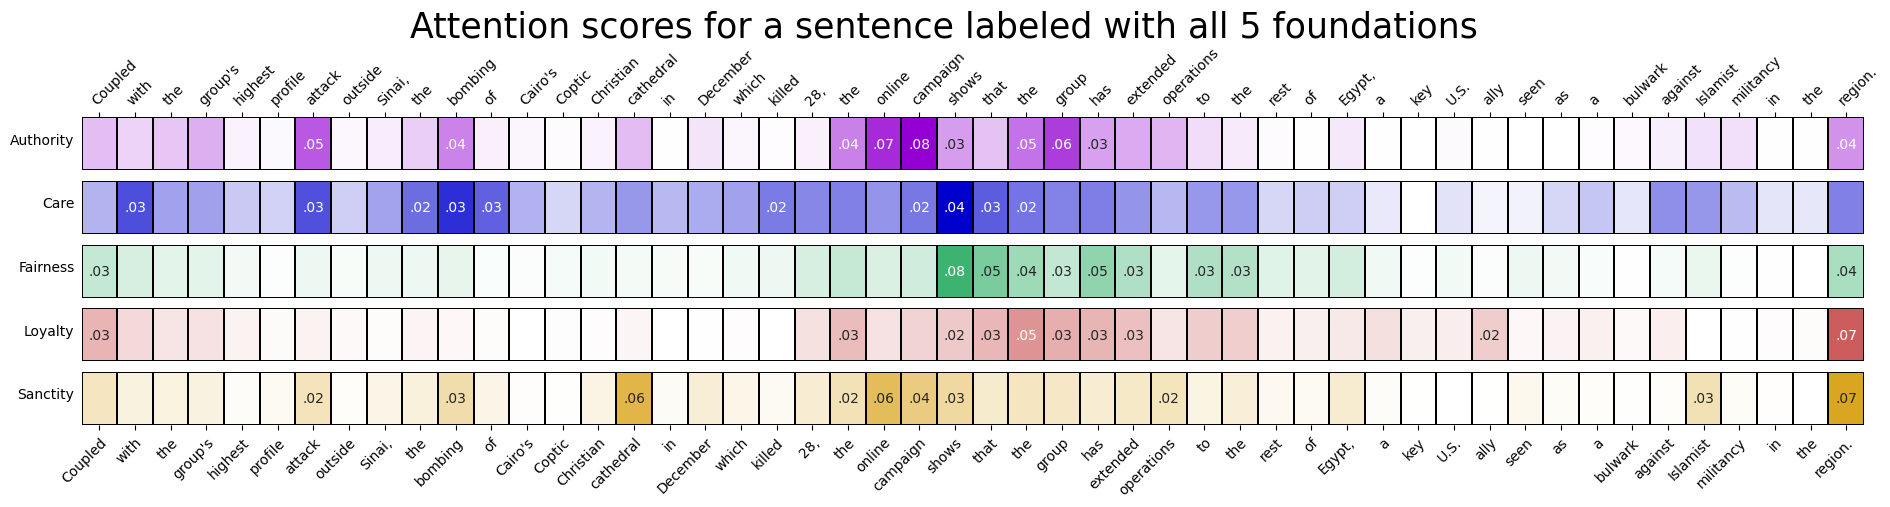

In [34]:
import matplotlib
import seaborn as sns
from matplotlib.colors import ListedColormap
fig, axes = plt.subplots(5, 1, figsize=(23, 4))
COLORS = ["darkviolet", "mediumblue", "mediumseagreen", "indianred", "goldenrod"]
cmap_names = ["Purples", "Blues", "Greens", "Reds", "YlOrBr"]
for i, (f, color) in enumerate(zip(FOUNDATIONS, COLORS)):
    ax = axes[i]
    row = attns[[f]].T
    
    # Annotate only the top 10-scoring scores
    annot_matrix = annotate_top10(row)
    
    # Design a color map for this heatmap
    r, g, b = matplotlib.colors.to_rgb(color)
    N = 256
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(r, 1, N)
    vals[:, 1] = np.linspace(g, 1, N)
    vals[:, 2] = np.linspace(b, 1, N)
    newcmp = ListedColormap(vals[::-1])
    
    sns.heatmap(attns[[f]].T, 
                cmap=newcmp,#sns.color_palette(cmap_name, 25), 
                ax=ax,
                cbar=False,
                annot=annot_matrix,
                fmt="",
                linewidths=0.01,
                linecolor="black",
                )
    ax.set_yticks([])
    ax.text(x=-0.2, y=0.5, s=f.capitalize(), ha="right")
    if i == 0:
        ax.xaxis.tick_top()
        ax.set_xticklabels(attns.index, rotation=45, ha='left', va="bottom", rotation_mode='anchor')
    elif i < 4:
        ax.set_xticks([])
    else:
        ax.set_xticklabels(attns.index, rotation=45, ha='right', va="top", rotation_mode='anchor')
fig.suptitle("Attention scores for a sentence labeled with all 5 foundations", size=25, y = 1.15)
plt.savefig("figs/attention_scores_roberta_one_example.pdf", bbox_inches="tight")
plt.show()

## Print the top-scoring examples

In [35]:
news_data = data.iloc[:34262,:]
reddit_data = data.iloc[34262:34262 + 17886, :]
twitter_data = data.iloc[34262 + 17886:, :]

In [36]:
foundation = "sanctity"
f_idx = FOUNDATIONS.index(foundation)

# Get the test datasets
news_test    = news_data[news_data[f"{foundation}_fold"] == 0]
twitter_test = twitter_data[twitter_data[f"{foundation}_fold"] == 0]
reddit_test  = reddit_data[reddit_data[f"{foundation}_fold"] == 0]


print("news", news_test.shape[0])
print("reddit", reddit_test.shape[0])
print("twitter", twitter_test.shape[0])

data_test = data[data[f"{foundation}_fold"] == 0]
print("total", data_test.shape[0])

# Get the examples with ground-truth = 0
news_test    = news_test[news_test[f"{foundation}_label"] == 1]
twitter_test = twitter_test[twitter_test[f"{foundation}_label"] == 1]
reddit_test  = reddit_test[reddit_test[f"{foundation}_label"] == 1]

news 2522
reddit 1789
twitter 3499
total 7810


In [37]:
news_best_scores = news_test.sort_values(f"{foundation}_score", ascending=True).iloc[0]
twitter_best_scores = twitter_test.sort_values(f"{foundation}_score", ascending=True).iloc[0]
reddit_best_scores = reddit_test.sort_values(f"{foundation}_score", ascending=True).iloc[0]

authority_label    1
care_label         0
fairness_label     0
loyalty_label      0
sanctity_label     1
Name: 62057, dtype: object
RT @JRehling: Tiananmen Square, Beijing, 1989.
#FreddieGray protests, Baltimore, 2015.
Photo by @cmcampbell6 http://t.co/8FDIbYEjXW


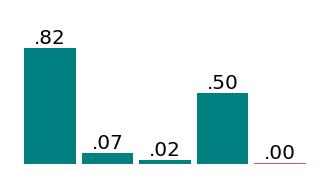

In [38]:
print(twitter_best_scores[[f"{foundation}_label" for foundation in FOUNDATIONS]])
print(twitter_best_scores[f"sentence"])

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
hist = twitter_best_scores[[f"{foundation}_score" for foundation in FOUNDATIONS]].tolist()
ax.bar(range(5), hist, color="teal", width=0.9)
ax.bar([f_idx], [hist[f_idx]], color="indianred", width=0.9)
for i, val in enumerate(hist):
    ax.text(x=i, y=val, s=str(val)[1:4], size="x-large", va="bottom", ha="center")
ax.set_xticks(range(5), FOUNDATIONS)
ax.set_ylim([0, 1.1])
ax.set_yticks([])
ax.set_xticks([])

sns.despine(top=True, left=True, right=True, bottom=True, ax=ax)
plt.show()

authority_label     0
care_label         -1
fairness_label      0
loyalty_label      -1
sanctity_label      1
Name: 31405, dtype: object
The author of the prior study, Roland Fryer, Jr., an economics professor at Harvard University, declined a request to comment on the current study.


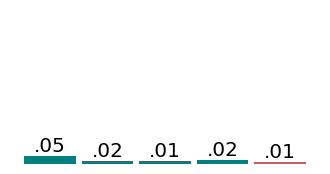

In [39]:
print(news_best_scores[[f"{foundation}_label" for foundation in FOUNDATIONS]])
print(news_best_scores[f"sentence"])

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
hist = news_best_scores[[f"{foundation}_score" for foundation in FOUNDATIONS]].tolist()
ax.bar(range(5), hist, color="teal", width=0.9)
ax.bar([f_idx], [hist[f_idx]], color="indianred", width=0.9)
for i, val in enumerate(hist):
    ax.text(x=i, y=val, s=str(val)[1:4], size="x-large", va="bottom", ha="center")
ax.set_xticks(range(5), FOUNDATIONS)
ax.set_ylim([0, 1.1])
ax.set_yticks([])
ax.set_xticks([])

sns.despine(top=True, left=True, right=True, bottom=True, ax=ax)
plt.show()

authority_label    0
care_label         0
fairness_label     0
loyalty_label      0
sanctity_label     1
Name: 34685, dtype: object
Without a coherent economic message these movements falter quickly. Single issue platforms make for a good protest party, but thats not reason enough to vote. For Le Pen I'm not so sure, France is economically more in the dumps but Le Pens economic message is so asinine, it wouldn't make much sense for anybody. Trump and Brexit had some economic validity, but this movement might be out of gas.


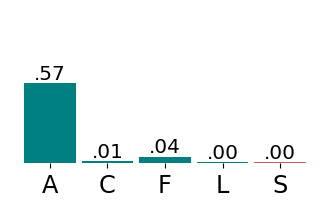

In [40]:
print(reddit_best_scores[[f"{foundation}_label" for foundation in FOUNDATIONS]])
print(reddit_best_scores[f"sentence"])

fig, ax = plt.subplots(1, 1, figsize=(4, 2))
hist = reddit_best_scores[[f"{foundation}_score" for foundation in FOUNDATIONS]].tolist()
ax.bar(range(5), hist, color="teal", width=0.9)
ax.bar([f_idx], [hist[f_idx]], color="indianred", width=0.9)
for i, val in enumerate(hist):
    ax.text(x=i, y=val, s=str(val)[1:4], size="x-large", va="bottom", ha="center")
ax.set_xticks(range(5), FOUNDATIONS)
ax.set_ylim([0, 1.1])
ax.set_yticks([])
ax.set_xticks(np.arange(5), ["A", "C", "F", "L", "S"], size="xx-large")

sns.despine(top=True, left=True, right=True, bottom=True, ax=ax)
plt.show()

## Moral argument dataset

Argument mining 2020 paper

In [41]:
mining_dataset = pd.read_csv("mfd/other_mf_corpora/moral_argument_mining_2020/data/morality_arguments_pred.csv", index_col=0)
mining_dataset

,Unnamed: 0,care,fairness,loyalty,authority,sanctity,argument,authority_score,care_score,fairness_score,loyalty_score,sanctity_score
0,0,1,0,0,0,1,Americans spend billions on bottled water ever...,0.13,0.80,0.14,0.01,0.03
1,1,0,0,1,0,0,Banning plastic bottled water would be a huge ...,0.06,0.68,0.05,0.02,0.02
2,2,0,0,1,0,0,We will be able to ban water bottles until we ...,0.37,0.16,0.20,0.01,0.06
3,3,1,0,0,0,0,Western Europe consumes almost 50% of the worl...,0.25,0.18,0.18,0.13,0.13
4,4,0,0,0,0,0,U.S. alone grew by over 13%. According to rese...,0.06,0.03,0.06,0.05,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...
315,315,1,0,0,0,0,William Farquhar had helped more citizen of Si...,0.28,0.28,0.11,0.06,0.02
316,316,0,0,1,1,0,"To me, a founder would be a leader, well respe...",0.92,0.05,0.25,0.51,0.02
317,317,1,0,0,0,0,Raffles neglected Singapore when he went aroun...,0.49,0.11,0.43,0.02,0.05
318,318,1,0,1,0,0,"Raffles came and left Singapore, returning aft...",0.12,0.03,0.07,0.03,0.02


In [42]:
for f in FOUNDATIONS:
    print(f)
    y_test = mining_dataset[f]
    y_test_score = mining_dataset[f + "_score"]
    y_test_pred = np.array([y >= thresholds[f] for y in y_test_score], dtype=int)
    print(roc_auc_score(y_true=y_test, y_score=y_test_score))
    print(f1_score(y_true=y_test, y_pred=y_test_pred))

authority
0.8087416735103568
0.3875
care
0.8551218896046482
0.6827586206896551
fairness
0.8641701047286576
0.46706586826347307
loyalty
0.848
0.4590163934426229
sanctity
0.8287049223479863
0.5179856115107913


## Moral integrity corpus

In [43]:
mic = pd.read_csv("mfd/other_mf_corpora/moral_intergrity_acl2022/data/MIC_without_liberty_pred.csv", index_col=0)
mic

,Unnamed: 0,rot,care,fairness,loyalty,authority,sanctity,authority_score,care_score,fairness_score,loyalty_score,sanctity_score
0,4,It's good to listen to your parents' advice.,0,0,0,1,0,0.73,0.31,0.18,0.34,0.01
1,29,Do good when you have the ability.,1,1,0,1,1,0.02,0.05,0.06,0.02,0.20
2,35,It is evil to physically abuse your children.,0,0,1,0,0,0.05,0.98,0.35,0.02,0.98
3,73,It's wrong to be biased against certain parts ...,0,1,0,0,0,0.04,0.16,0.93,0.26,0.04
4,85,It is wrong to be in a fight,1,0,1,1,0,0.05,0.08,0.28,0.07,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...
8668,113723,It's bad to not think,1,1,0,0,0,0.01,0.08,0.03,0.03,0.03
8669,113761,You shouldn't judge someone's personality base...,0,1,0,0,0,0.05,0.47,0.66,0.05,0.06
8670,113769,It's important to respect the law.,0,1,0,0,0,0.95,0.25,0.72,0.19,0.13
8671,113803,It's good to be introspective and to ask thoug...,1,0,0,0,1,0.04,0.30,0.07,0.10,0.13


In [44]:
for f in FOUNDATIONS:
    print(f)
    y_test = mic[f]
    y_test_score = mic[f + "_score"]
    y_test_pred = np.array([y >= thresholds[f] for y in y_test_score], dtype=int)
    print(roc_auc_score(y_true=y_test, y_score=y_test_score))
    print(f1_score(y_true=y_test, y_pred=y_test_pred))

authority
0.7567361105969858
0.4755862068965517
care
0.7001114273396409
0.6919402985074627
fairness
0.6658648566083372
0.4137819996779907
loyalty
0.7290260610027397
0.4881656804733728
sanctity
0.6643891118356229
0.2804651162790698
